## Import necessary modules

In [5]:
from WholeBrain.Observables.swfcd import swFCD
from WholeBrain.Observables.metastability import Metastability
from WholeBrain.Observables.event_based_intrinsic_ignition import EventBasedIntrinsicIgnition
# from WholeBrain.Observables.phase_based_intrinsic_ignition import PhaseBasedIntrinsicIgnition
from WholeBrain.Filters.bold_band_pass_filter import BOLDBandPassFilter
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2
# import matplotlib.pyplot as plt
from subjects import *

## Setup parameters

In [6]:
data_dir = "data"

## Load and print Subjects

In [7]:
subjects = Subjects()
subjects.initialize(data_dir)

print("************************* Subjects Info *************************")
subjects.pretty_print()
print("*****************************************************************")

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)    # REGIONS WITH TUMOR
sub-CON01       2100.0          none                           0.0             0              
sub-CON02       2100.0          none                           0.0             0              
sub-CON03       2100.0          none                           0.0             0              
sub-CON04       2100.0          none                           0.0             0              
sub-CON05       2400.0          none                           0.0             0              
sub-CON06       2400.0          none                           0.0             0              
sub-CON07       2400.0          none                           0.0             0              
sub-CON08       2400.0          none                           0.0             0              
sub-CON09       2400.0          none                           0.0        

## Partition Subjects into Subsets and print statistics

In [8]:
subjects_subsets = {
    'Control':      subjects.get_control_subset(),
    'Tumor':        subjects.get_tumor_subset(),
    'Meningioma':   subjects.get_meningioma_subset(),
    'Glioma':       subjects.get_glioma_subset(),
    '>= 10cm³':     subjects.get_plus_x_cm3_subset(10.0),
    '>= 15cm³':     subjects.get_plus_x_cm3_subset(15.0),
    '>= 20cm³':     subjects.get_plus_x_cm3_subset(20.0),
    '>= 30cm³':     subjects.get_plus_x_cm3_subset(30.0),
}

print("************************* Subjects Subsets Info *************************")
print(f'\033[94m', end="")
print('{:<15} {:<15} {:<15} {:<15}'.format(
    'NAME', '# TOTAL COUNT', '# MENINGIOMA', '# GLIOMA'
))
print(f'\033[0m', end="")
for k, v in subjects_subsets.items():
    print('{:<15} {:<15} {:<15} {:<15}'.format(
        k, str(v.count()), str(v.get_meningioma_subset().count()), str(v.get_glioma_subset().count())
    ))
print("*************************************************************************")

************************* Subjects Subsets Info *************************
NAME            # TOTAL COUNT   # MENINGIOMA    # GLIOMA       
Control         11              0               0              
Tumor           25              14              11             
Meningioma      14              14              0              
Glioma          11              0               11             
>= 10cm³        15              5               10             
>= 15cm³        11              4               7              
>= 20cm³        7               3               4              
>= 30cm³        6               2               4              
*************************************************************************


## Compute swFCD
&#x2BC1; **TODO: Filter parameters?????**

In [9]:
def compute_preop_swFCD_dk68():
    preop_ts_dk68 = subjects.filter_preop_ts_dk68()
    result = dict()
    swFCD_operator = swFCD()

    for sub_id, ts_dk68 in preop_ts_dk68.items():
        tr = subjects.get_subject_by_id(sub_id).get_fmri_tr()/1000.0
        ms_dk68 = swFCD_operator.from_fMRI(
            ts_dk68,
            # TODO: Filter parameters???
            BOLD_filter=BOLDBandPassFilter(tr=tr, flp=0.02, fhi=0.1, k=2, remove_strong_artifacts=3.0)
        )
        result[sub_id] = ms_dk68
    return result

preop_swFCD_dk68 = compute_preop_swFCD_dk68()

## TODO: Do things with swFCD

In [10]:
# TODO: Super useful computations and plotting with swFCD here!

## Compute metastability

In [11]:
def compute_preop_metastability_dk68():
    preop_ts_dk68 = subjects.filter_preop_ts_dk68()
    result = dict()
    ms_operator = Metastability()

    for sub_id, ts_dk68 in preop_ts_dk68.items():
        tr = subjects.get_subject_by_id(sub_id).get_fmri_tr()/1000.0
        ms_dk68 = ms_operator.from_fMRI(
            ts_dk68,
            BOLD_filter=BOLDBandPassFilter(tr=tr, flp=0.007, fhi=0.07, k=2, remove_strong_artifacts=3.0)
        )
        result[sub_id] = ms_dk68
    return result

preop_metastability_dk68 = compute_preop_metastability_dk68()

## Plot metastability Box

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. >= 15cm³: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.155e-02 U_stat=9.600e+01


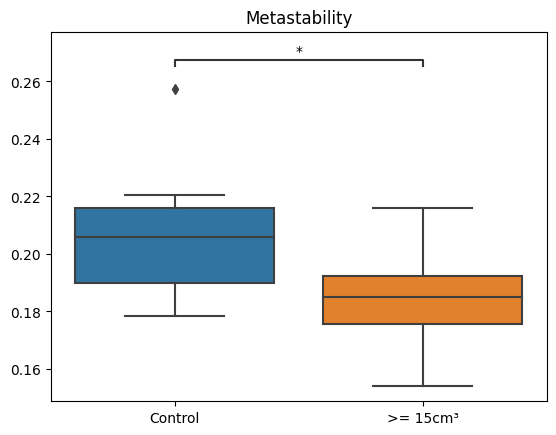

In [12]:
def plot_metastability_box(subjects_ms):
    split_data = {
        'Control': [v.metastability for k, v in subjects_subsets['Control'].keep_only_from_this_set(subjects_ms).items()],
        # 'Tumor': [v.metastability for k, v in subjects_subsets['Tumor'].keep_only_from_this_set(subjects_ms).items()],
        # 'Meningioma': [v.metastability for k, v in subjects_subsets['Meningioma'].keep_only_from_this_set(subjects_ms).items()],
        # 'Glioma': [v.metastability for k, v in subjects_subsets['Glioma'].keep_only_from_this_set(subjects_ms).items()],
        # '>= 10cm³': [v.metastability for k, v in subjects_subsets['>= 10cm³'].keep_only_from_this_set(subjects_ms).items()],
        '>= 15cm³': [v.metastability for k, v in  subjects_subsets['>= 15cm³'].keep_only_from_this_set(subjects_ms).items()],
        # '>= 20cm³': [v.metastability for k, v in subjects_subsets['>= 20cm³'].keep_only_from_this_set(subjects_ms).items()],
        # '>= 30cm³': [v.metastability for k, v in subjects_subsets['>= 30cm³'].keep_only_from_this_set(subjects_ms).items()],
    }

    plotComparisonAcrossLabels2(
        split_data,
        graphLabel='Metastability'
    )

plot_metastability_box(preop_metastability_dk68)

## Compute Event Based Intrinsic Ignition
&#x2BC1; **NOTE: If we use TR length 8 for the 2100ms TR scans and length 7 for the 2400ms scans (or multiples of them), then we have the same windows time frame for each subject (16800ms).**

In [13]:
def compute_preop_event_based_intrinsic_ignition():
    preop_ts_dk68 = subjects.filter_preop_ts_dk68()
    result = dict()

    for sub_id, ts_dk68 in preop_ts_dk68.items():

        tr_ms = subjects.get_subject_by_id(sub_id).get_fmri_tr()

        # If we use length 8 for the 2100ms TR scans and length 7 for the 2400ms scans (or multiple of them), then we have the same windows
        # time frame for each subject (16800ms)
        ignition_tr_length = None
        if np.isclose(tr_ms, 2400.0):
            ignition_tr_length = 7
        elif np.isclose(tr_ms, 2100.0):
            ignition_tr_length = 8
        assert ignition_tr_length is not None, "Ups... TR length not 2100 or 2400..."

        ebig_operator = EventBasedIntrinsicIgnition(ignition_tr_length=ignition_tr_length)

        ebig_dk68 = ebig_operator.from_fMRI(
            ts_dk68,
            # flp=0.01, fhi=0.1
            #   Tagliazucchi, Enzo, Pablo Balenzuela, Daniel Fraiman, and Dante R. Chialvo.
            #       “Criticality in Large-Scale Brain FMRI Dynamics Unveiled by a Novel
            #       Point Process Analysis.” Frontiers in Physiology 3 (2012). https://doi.org/10.3389/fphys.2012.00015.
            #
            # flp=0.04, fhi=0.07. NOTE: This paper uses phased based intrinsic ignition.
            #   Glerean, Enrico, Juha Salmi, Juha M. Lahnakoski, Iiro P. Jääskeläinen, and Mikko Sams.
            #       “Functional Magnetic Resonance Imaging Phase Synchronization as a Measure of Dynamic Functional Connectivity.”
            #       Brain Connectivity 2, no. 2 (April 2012): 91–101. https://doi.org/10.1089/brain.2011.0068.
            BOLD_filter=BOLDBandPassFilter(tr=tr_ms/1000.0, flp=0.01, fhi=0.1, k=2, remove_strong_artifacts=3.0)
        )
        result[sub_id] = ebig_dk68

    return result

preop_ebii_dk68 = compute_preop_event_based_intrinsic_ignition()

## Plot Event Based Intrinsict Ignition (mignition)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Glioma: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.557e-02 U_stat=9.500e+01
Control vs. >= 10cm³: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.563e-02 U_stat=1.260e+02


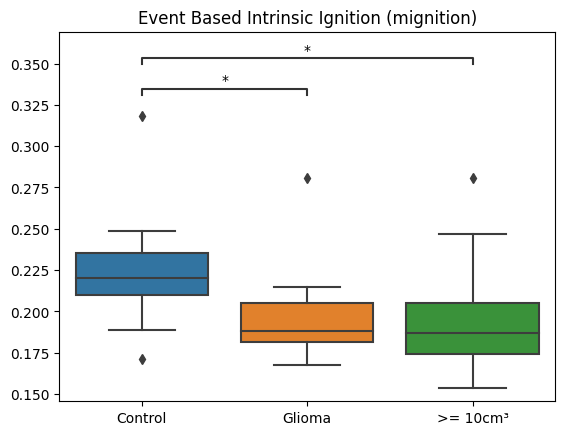

In [14]:
def plot_ebii_box(subjects_ebii):
    split_data = {
        'Control': [v.mignition for k, v in subjects_subsets['Control'].keep_only_from_this_set(subjects_ebii).items()],
        # 'Tumor': [v.mignition for k, v in subjects_subsets['Tumor'].keep_only_from_this_set(subjects_ebii).items()],
        # 'Meningioma': [v.mignition for k, v in subjects_subsets['Meningioma'].keep_only_from_this_set(subjects_ebii).items()],
        'Glioma': [v.mignition for k, v in subjects_subsets['Glioma'].keep_only_from_this_set(subjects_ebii).items()],
        '>= 10cm³': [v.mignition for k, v in subjects_subsets['>= 10cm³'].keep_only_from_this_set(subjects_ebii).items()],
        # '>= 15cm³': [v.mignition for k, v in  subjects_subsets['>= 15cm³'].keep_only_from_this_set(subjects_ebii).items()],
        # '>= 20cm³': [v.mignition for k, v in subjects_subsets['>= 20cm³'].keep_only_from_this_set(subjects_ebii).items()],
        # '>= 30cm³': [v.mignition for k, v in subjects_subsets['>= 30cm³'].keep_only_from_this_set(subjects_ebii).items()],
    }

    plotComparisonAcrossLabels2(
        split_data,
        graphLabel='Event Based Intrinsic Ignition (mignition)',
        pairs=[('Control', 'Glioma'), ('Control', '>= 10cm³')]
    )

plot_ebii_box(preop_ebii_dk68)